In [1]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import L2

from os.path import join
from os import listdir
from shutil import copy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
train_df = pd.read_csv("df//train_df.csv")
val_df = pd.read_csv("df//val_df.csv")
train_df.head()

,path,pH
0,close_seg\6\6K--56-_jpg-region_2.png,6
1,close_seg\6\6F--50-_jpg-region_2.png,6
2,close_seg\6\6K--3-_jpg-region_2.png,6
3,close_seg\6\6k--15-_jpg-region_2.png,6
4,close_seg\6\6F--43-_jpg-region_2.png,6


In [3]:
x_col = "path"
y_col = "pH"
batch_size = 32
epochs = 256
lr = 1e-5
image_size = (128,128)
channels = 3
shuffle = True
class_mode ="raw"
color_mode = "rgb"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    #  width_shift_range = 0.2,
                                    #  height_shift_range = 0.2, 
                                    #  zoom_range = 0.2,
                                     shear_range = 0.5,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     rotation_range = 45,
                                     )
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                              x_col=x_col, y_col=y_col, has_ext=True, 
                                              class_mode=class_mode, target_size=image_size, 
                                              batch_size=batch_size, color_mode = color_mode,
                                              shuffle = shuffle)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                              x_col=x_col, y_col=y_col, has_ext=True, 
                                              class_mode=class_mode, target_size=image_size, 
                                              batch_size=batch_size, color_mode = color_mode,
                                              shuffle = shuffle)


Found 769 validated image filenames.
Found 192 validated image filenames.


In [25]:
model = Sequential()
model.add(Input(image_size+(channels,)))
model.add(Flatten())

model.add(Dense(units=256)) #, kernel_regularizer=L2()
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(units=2048))
model.add(ReLU())
model.add(Dropout(0.5))

model.add(BatchNormalization())

model.add(Dense(units=2048))
model.add(ReLU())

model.add(Dense(units=1, activation='linear'))



In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 49152)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               12583168  
                                                                 
 re_lu_6 (ReLU)              (None, 256)               0         
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 2048)              526336    
                                                                 
 re_lu_7 (ReLU)              (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)             

In [27]:
model.compile(optimizer=Adam(lr), loss='mean_squared_error', metrics=['mae'])

In [28]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-7)
es = EarlyStopping(monitor='val_loss', patience=13, mode="min")

history = model.fit(train_generator, validation_data = val_generator, 
                        epochs = epochs, callbacks=[reduce_lr, es], 
                        verbose = 1)

Epoch 1/256
25/25 [==============================] - 3s 81ms/step - loss: 66.1321 - mae: 8.0377 - val_loss: 57.5966 - val_mae: 7.5259 - lr: 1.0000e-05
Epoch 2/256
25/25 [==============================] - 2s 82ms/step - loss: 61.3943 - mae: 7.7362 - val_loss: 54.5451 - val_mae: 7.3205 - lr: 1.0000e-05
Epoch 3/256
25/25 [==============================] - 2s 83ms/step - loss: 56.6427 - mae: 7.4182 - val_loss: 54.9930 - val_mae: 7.3513 - lr: 1.0000e-05
Epoch 4/256
25/25 [==============================] - 2s 79ms/step - loss: 50.3706 - mae: 6.9913 - val_loss: 51.9610 - val_mae: 7.1431 - lr: 1.0000e-05
Epoch 5/256
25/25 [==============================] - 2s 83ms/step - loss: 41.1934 - mae: 6.2947 - val_loss: 42.5868 - val_mae: 6.4538 - lr: 1.0000e-05
Epoch 6/256
25/25 [==============================] - 2s 84ms/step - loss: 29.6832 - mae: 5.2757 - val_loss: 30.7906 - val_mae: 5.4555 - lr: 1.0000e-05
Epoch 7/256
25/25 [==============================] - 2s 82ms/step - loss: 18.6311 - mae: 4.039

In [29]:
train_loss = history.history['loss']
train_mae = history.history['mae']
val_loss = history.history['val_loss']
val_mae = history.history['val_mae']

best_epoch = np.argmin(np.array(val_loss))

print("Best Epoch: ", best_epoch)
print("Final Train Loss: {:.4f}".format(train_loss[best_epoch]))
print("Final Validation Loss: {:.4f}".format(val_loss[best_epoch]))
print("Final Train MAE: {:.4f}".format(train_mae[best_epoch]))
print("Final Test MAE: {:.4f}".format(val_mae[best_epoch]))

Best Epoch:  8
Final Train Loss: 6.9356
Final Validation Loss: 18.4023
Final Train MAE: 2.1466
Final Test MAE: 4.0914


In [30]:
import warnings
warnings.filterwarnings("ignore")

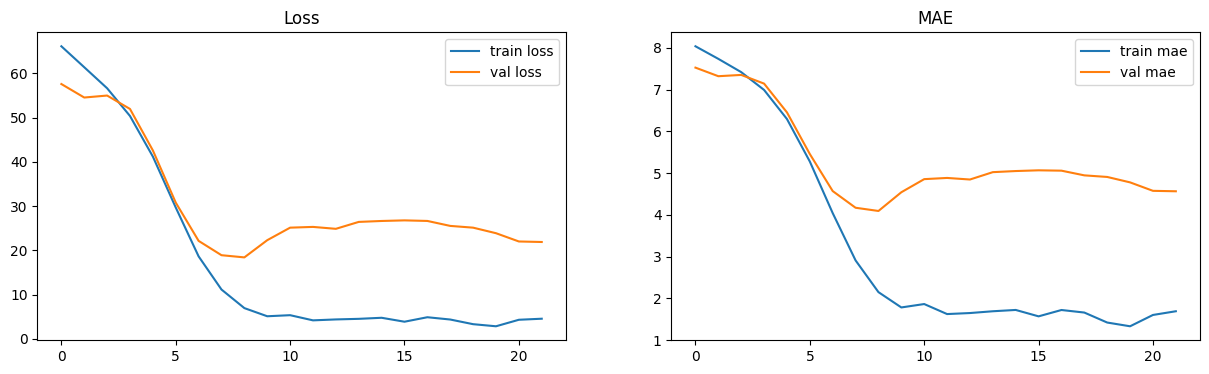

In [31]:

fig, ax = plt.subplots(1,2, figsize=(15,4))
sns.lineplot(train_loss , ax=ax[0], label='train loss')
sns.lineplot(val_loss, ax=ax[0], label='val loss')
# ax[0].legend(labels=['train loss','validation loss'],loc="upper right")
ax[0].set_title('Loss')

sns.lineplot(train_mae, ax=ax[1], label='train mae')
sns.lineplot(val_mae, ax=ax[1], label='val mae')
# ax[1].legend(labels=['train acc','validation acc'],loc="upper right")
ax[1].set_title('MAE')

plt.show()


In [32]:
tester = next(val_generator)

In [33]:
test = tester[0][12]
truth = tester[1][12]

result = round(model.predict(test.reshape(1,image_size[0],image_size[1],channels))[0][0],2)
print('Truth:',truth)
print('Result:',result)


1/1 [==============================] - 0s 52ms/step
Truth: 7
Result: 2.75
